In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [3]:
#importing the main folder and excel file
data_dir = '/content/drive/MyDrive/Eye/'
excel = pd.read_csv(data_dir+'data_information (1).csv')
#dividing it into 3 folders
cnv=excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')]
normal=excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')]
drusen = excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
#making a sampled dataset which contain 300 images
cnv_subset = cnv.sample(n=400,random_state=42)
normal_subset = normal.sample(n=400,random_state=42)
drusen_subset = drusen.sample(n=400,random_state=42)
sampled_data = pd.concat([cnv_subset, normal_subset, drusen_subset], ignore_index=True)
drusen = pd.concat([normal_subset, drusen_subset], ignore_index=True)
cnv=pd.concat([cnv_subset, normal_subset], ignore_index=True)

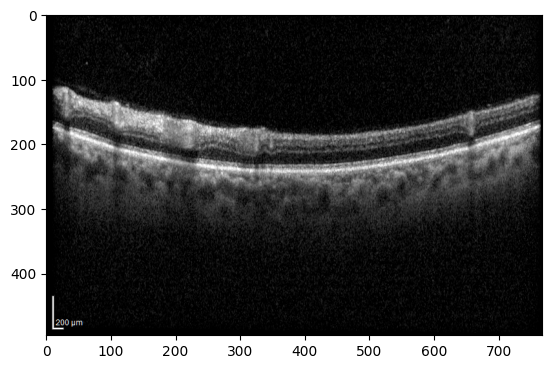

In [ ]:
import cv2
images=[]
for i in cnv['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

# **mean** **filter**

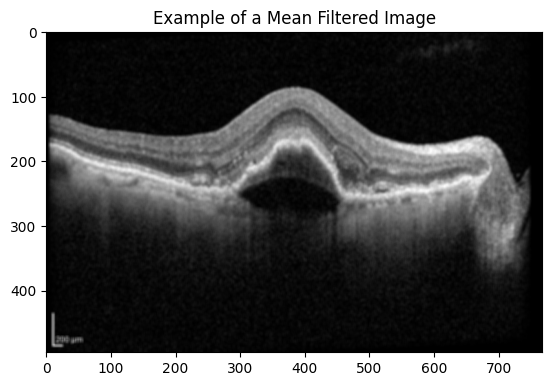

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
# Base directory containing the images
save_dir = '/content/drive/MyDrive/FilteredImages/'  # Directory to save filtered images

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load images, apply mean filter, and save filtered images
for idx, entry in cnv.iterrows():
    img_path = os.path.join(data_dir, entry['Directory'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if img is not None:
        # Apply mean filter
        kernel_size = (5, 5)  # Example kernel size for the mean filter
        img_filtered = cv2.blur(img, kernel_size)

        # Save the filtered image
        save_path = os.path.join(save_dir, os.path.basename(entry['Directory']))
        cv2.imwrite(save_path, img_filtered)

# Example of loading a filtered image to display
filtered_image_path = os.path.join(save_dir, os.path.basename(cnv.iloc[0]['Directory']))
filtered_image = cv2.imread(filtered_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(filtered_image, cmap='gray')
plt.title('Example of a Mean Filtered Image')
plt.show()



In [ ]:
import cv2
import numpy as np
import os
from skimage import feature
filtered_data_dir = '/content/drive/MyDrive/FilteredImages/'
# List to store LBP features
lbp_features = []

# Iterate over the rows in the 'Directory' column of cnv
for index, row in cnv.iterrows():
    # Read the filtered image
    filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(row['Directory']))
    filtered_img = cv2.imread(filtered_img_path)

    # Check if the filtered image was successfully loaded
    if filtered_img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        # Append LBP features to the list
        lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)


# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

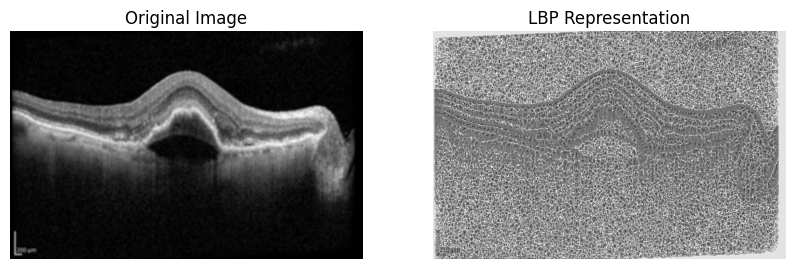

In [ ]:
import cv2
import os
from skimage import feature
import matplotlib.pyplot as plt

# Function to compute LBP features for an image
def compute_lbp(image):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute LBP features
    lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return lbp, hist

# Choose an image from the dataset (you can change the index as needed)
image_index = 0
filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(cnv.iloc[image_index]['Directory']))
filtered_img = cv2.imread(filtered_img_path)

# Compute LBP features for the chosen image
lbp, hist = compute_lbp(filtered_img)

# Plot the original image and its LBP representation
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# LBP representation
plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Representation')
plt.axis('off')

plt.show()

In [ ]:
# Assuming you have your target vector y as a pandas Series
y = cnv['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'CNV': 0, 'NORMAL': 1})
X = lbp_features

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.5     0.48125 0.45625 0.43125 0.5125 ]
Mean Accuracy: 0.47624999999999995


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.50625 0.5     0.46875 0.5     0.59375]
Mean Accuracy with Logistic Regression: 0.51375
Standard Deviation of Accuracy with Logistic Regression: 0.04209364560120684


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.95625 0.925   0.94375 0.9375  0.9    ]
Mean Accuracy with KNN: 0.9325000000000001
Standard Deviation of Accuracy with KNN: 0.019121323175972944


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.475   0.5375  0.5875  0.58125 0.525  ]
Mean Accuracy with Naive Bayes: 0.54125
Standard Deviation of Accuracy with Naive Bayes: 0.041003048667141835


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [1.      0.9875  0.9875  0.99375 0.96875]
Mean Accuracy with XGBoost: 0.9875
Standard Deviation of Accuracy with XGBoost: 0.010458250331675948


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
num_folds = 5

# Initialize the SVM classifier
svm_classifier = SVC(kernel='sigmoid')

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_dev_accuracy)

Cross-validation scores: [0.525   0.475   0.45    0.41875 0.49375]
Mean Accuracy: 0.4725
Standard Deviation of Accuracy: 0.03635759893062247


Gamma: 0.001, Mean Accuracy: 0.46624999999999994
Gamma: 0.01, Mean Accuracy: 0.46624999999999994
Gamma: 0.1, Mean Accuracy: 0.46624999999999994
Gamma: 1, Mean Accuracy: 0.45625
Gamma: 10, Mean Accuracy: 0.6024999999999999


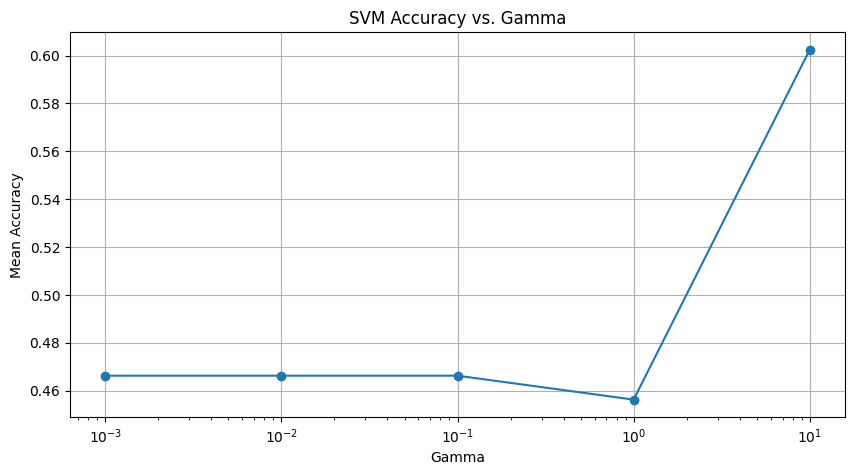

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.4875  0.50625 0.45625 0.4375  0.55   ]
Degree: 1, Mean Accuracy: 0.4875
Degree: 2, Cross-validation scores: [0.6375  0.69375 0.6375  0.56875 0.60625]
Degree: 2, Mean Accuracy: 0.6287499999999999
Degree: 3, Cross-validation scores: [0.7375 0.7875 0.75   0.7125 0.675 ]
Degree: 3, Mean Accuracy: 0.7324999999999999
Degree: 4, Cross-validation scores: [0.7625  0.8125  0.775   0.74375 0.69375]
Degree: 4, Mean Accuracy: 0.7575000000000001
Degree: 5, Cross-validation scores: [0.76875 0.7625  0.78125 0.80625 0.70625]
Degree: 5, Mean Accuracy: 0.765


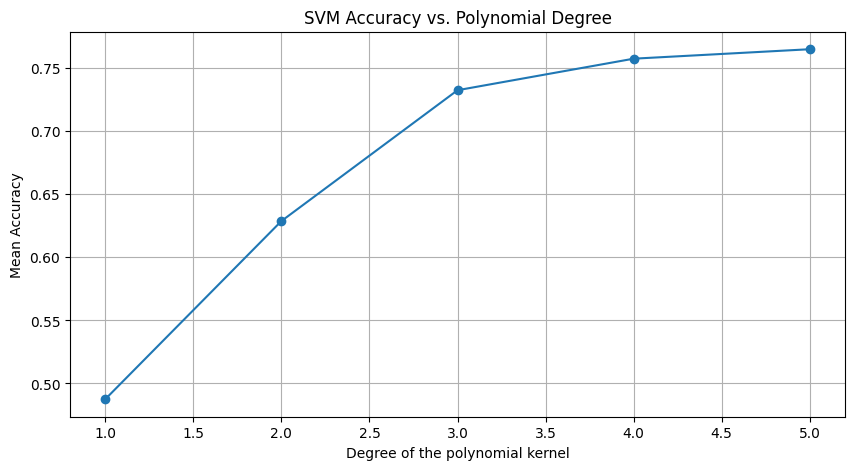

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

# **guassian**

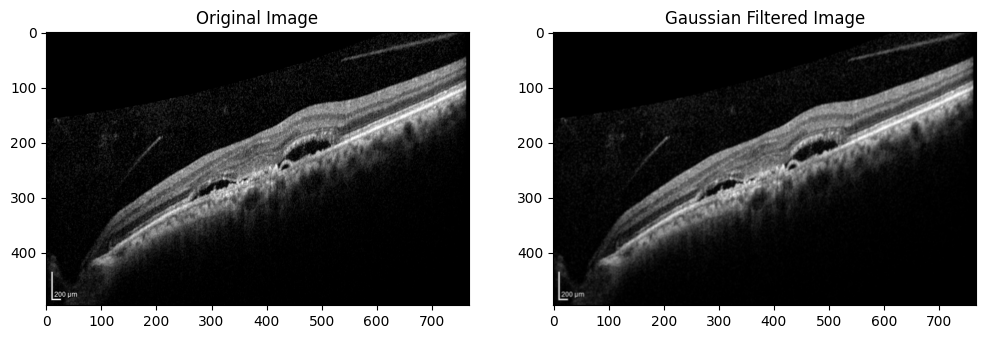

Directory /content/drive/MyDrive/GaussianFilteredImages/028_Normal.tif could not be accessed or does not exist.


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Define your base directory and new directory for the filtered images
data_dir = '/content/drive/MyDrive/Eye/'
filtered_dir = '/content/drive/MyDrive/GaussianFilteredImages/'

# Create the filtered images directory if it doesn't already exist
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)

for idx, entry in cnv.iterrows():
    img_path = os.path.join(data_dir, entry['Directory'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        # Apply Gaussian Blur
        filtered_img = cv2.GaussianBlur(img, (3, 3), 0)

        # Save the filtered image
        save_path = os.path.join(filtered_dir, os.path.basename(entry['Directory']))
        cv2.imwrite(save_path, filtered_img)

        # Optionally, show the first image's original and filtered version for verification
        if idx == 0:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(filtered_img, cmap='gray')
            plt.title('Gaussian Filtered Image')
            plt.show()
    else:
        print(f"Failed to load image at {img_path}")
else:
    print(f"Directory {save_path} could not be accessed or does not exist.")


In [ ]:
import cv2
import numpy as np
import os
from skimage import feature
filtered_data_dir = '/content/drive/MyDrive/GaussianFilteredImages'
# List to store LBP features
lbp_features = []

# Iterate over the rows in the 'Directory' column of cnv
for index, row in cnv.iterrows():
    # Read the filtered image
    filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(row['Directory']))
    filtered_img = cv2.imread(filtered_img_path)

    # Check if the filtered image was successfully loaded
    if filtered_img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        # Append LBP features to the list
        lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)


# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

LBP features shape: (800, 9)
Sample LBP features:
[[0.0261283  0.05199408 0.06008747 0.15735782 0.21131552 0.15384272
  0.09011677 0.05607884 0.19307848]
 [0.02663233 0.04593782 0.06259713 0.16659579 0.2312773  0.16232989
  0.08819252 0.05098864 0.16544859]
 [0.01481382 0.03388829 0.03325038 0.1273574  0.17298807 0.13277312
  0.06368658 0.0414304  0.37981193]
 [0.01961001 0.03542664 0.04569105 0.13561355 0.1832131  0.12815283
  0.07236276 0.03978705 0.34014302]
 [0.03316375 0.05806084 0.07190598 0.16352172 0.22055612 0.15827925
  0.09110121 0.0601216  0.14328955]]


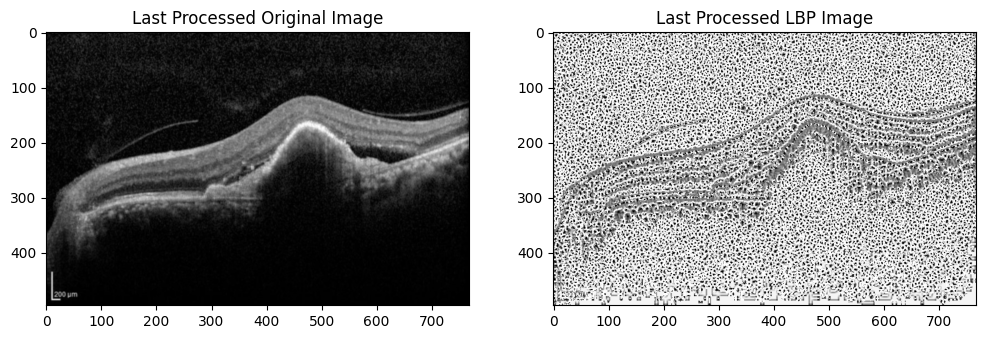

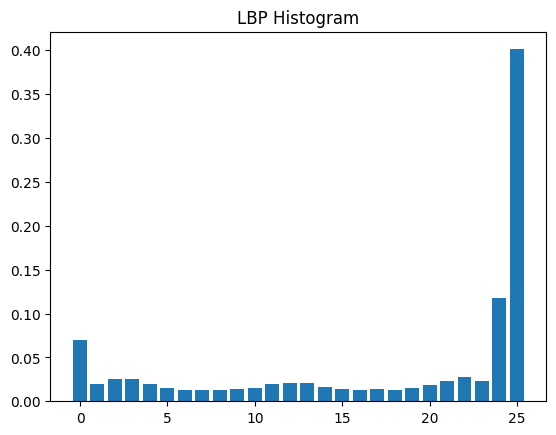

In [ ]:

if lbp_image is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Last Processed Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title('Last Processed LBP Image')
    plt.show()

    plt.figure()
    plt.title('LBP Histogram')
    plt.bar(np.arange(len(lbp_hist)), lbp_hist, width=0.8)
    plt.show()
else:
    print("No images were processed.")

In [ ]:
# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

LBP features shape: (800, 9)
Sample LBP features:
[[0.0261283  0.05199408 0.06008747 0.15735782 0.21131552 0.15384272
  0.09011677 0.05607884 0.19307848]
 [0.02663233 0.04593782 0.06259713 0.16659579 0.2312773  0.16232989
  0.08819252 0.05098864 0.16544859]
 [0.01481382 0.03388829 0.03325038 0.1273574  0.17298807 0.13277312
  0.06368658 0.0414304  0.37981193]
 [0.01961001 0.03542664 0.04569105 0.13561355 0.1832131  0.12815283
  0.07236276 0.03978705 0.34014302]
 [0.03316375 0.05806084 0.07190598 0.16352172 0.22055612 0.15827925
  0.09110121 0.0601216  0.14328955]]


In [ ]:
# Assuming you have your target vector y as a pandas Series
y = cnv['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'CNV': 0, 'NORMAL': 1})
X = lbp_features

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.5     0.48125 0.45625 0.43125 0.5125 ]
Mean Accuracy: 0.47624999999999995


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="rbf")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.50625 0.54375 0.49375 0.54375 0.4875 ]
Mean Accuracy: 0.5149999999999999


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.55625 0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.48125


Gamma: 0.001, Mean Accuracy: 0.47000000000000003
Gamma: 0.01, Mean Accuracy: 0.47000000000000003
Gamma: 0.1, Mean Accuracy: 0.47000000000000003
Gamma: 1, Mean Accuracy: 0.47125000000000006
Gamma: 10, Mean Accuracy: 0.50625


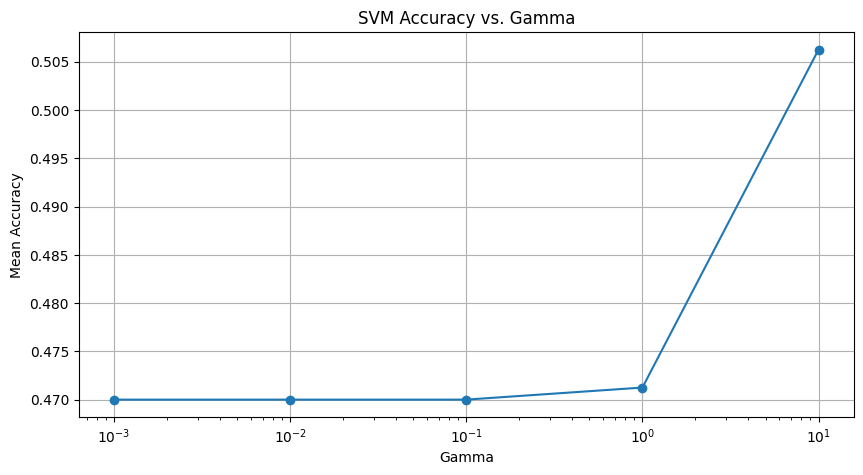

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.41875 0.4875  0.4375  0.43125 0.51875]
Degree: 1, Mean Accuracy: 0.45875000000000005
Degree: 2, Cross-validation scores: [0.5125  0.48125 0.4625  0.49375 0.5875 ]
Degree: 2, Mean Accuracy: 0.5075
Degree: 3, Cross-validation scores: [0.64375 0.6875  0.5875  0.5375  0.5625 ]
Degree: 3, Mean Accuracy: 0.60375
Degree: 4, Cross-validation scores: [0.76875 0.7625  0.71875 0.6875  0.68125]
Degree: 4, Mean Accuracy: 0.72375
Degree: 5, Cross-validation scores: [0.78125 0.775   0.74375 0.71875 0.65   ]
Degree: 5, Mean Accuracy: 0.7337499999999999


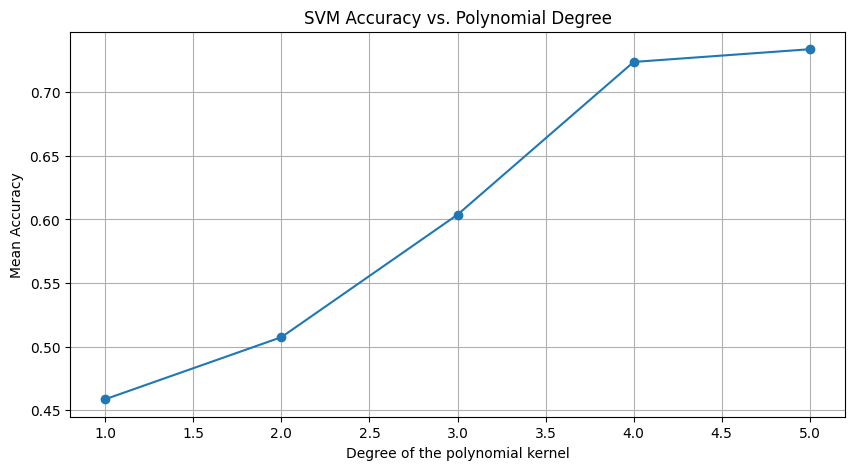

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

In [ ]:
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.55625 0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.48125


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.4875  0.49375 0.43125 0.475   0.60625]
Mean Accuracy with Logistic Regression: 0.4987500000000001
Standard Deviation of Accuracy with Logistic Regression: 0.05801400692936145


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.975   0.93125 0.95625 0.94375 0.91875]
Mean Accuracy with KNN: 0.945
Standard Deviation of Accuracy with KNN: 0.019525624189766645


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.38125 0.48125 0.4875  0.5125  0.5    ]
Mean Accuracy with Naive Bayes: 0.4725
Standard Deviation of Accuracy with Naive Bayes: 0.04687083314813169


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [1.      0.975   0.9875  0.98125 0.96875]
Mean Accuracy with XGBoost: 0.9825000000000002
Standard Deviation of Accuracy with XGBoost: 0.010752906583803292


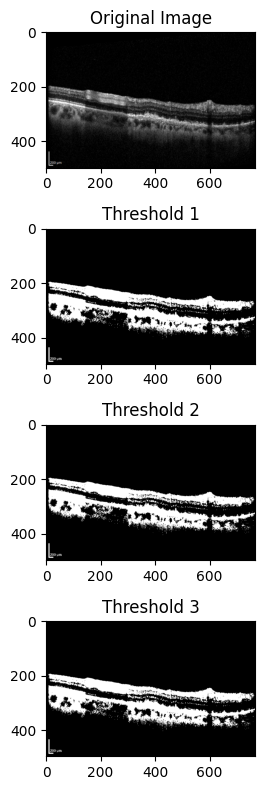

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform multilevel thresholding using Otsu's method
def multilevel_thresholding(image, num_thresholds):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding to find the initial threshold
    _, initial_threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Initialize the thresholds list with the initial threshold
    thresholds = [initial_threshold]

    # Calculate additional thresholds based on the initial threshold
    for _ in range(num_thresholds - 1):
        # Use the previous threshold as a mask to exclude pixels that have already been segmented
        masked_img = cv2.bitwise_and(gray_img, initial_threshold)

        # Apply Otsu's thresholding to find the next threshold
        _, threshold = cv2.threshold(masked_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Add the new threshold to the list
        thresholds.append(threshold)

        # Update the initial threshold by bitwise OR operation with the new threshold
        initial_threshold = cv2.bitwise_or(initial_threshold, threshold)

    return thresholds

# Select a random image from the dataset
idx = np.random.randint(len(cnv))
img_path = os.path.join(data_dir, cnv['Directory'].iloc[idx])
img = cv2.imread(img_path)

# Perform multilevel thresholding with 3 thresholds
num_thresholds = 3
thresholds = multilevel_thresholding(img, num_thresholds)

# Plot the original image and the thresholded images
plt.figure(figsize=(12, 8))
plt.subplot(num_thresholds + 1, 1, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

for i in range(num_thresholds):
    plt.subplot(num_thresholds + 1, 1, i + 2)
    plt.imshow(thresholds[i], cmap='gray')
    plt.title(f'Threshold {i+1}')

plt.tight_layout()
plt.show()

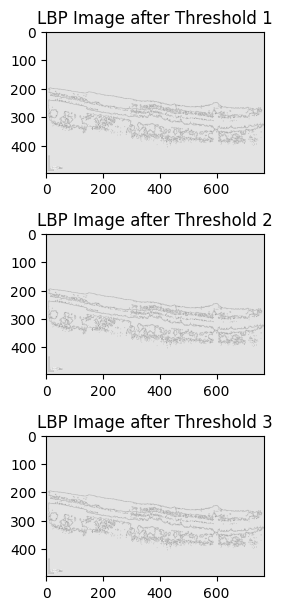

In [ ]:
from skimage.feature import local_binary_pattern

# Function to apply LBP
def apply_lbp(image):
    # Compute LBP
    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    return lbp_image

# Apply LBP to each thresholded image
lbp_images = [apply_lbp(threshold) for threshold in thresholds]

# Plot the LBP images
plt.figure(figsize=(12, 8))
for i, lbp_image in enumerate(lbp_images):
    plt.subplot(num_thresholds + 1, 1, i + 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title(f'LBP Image after Threshold {i+1}')

plt.tight_layout()
plt.show()

# **filetring**

In [ ]:
import cv2
import numpy as np
import os
from skimage import io  # Used for reading images if cv2 fails

# Define directories
data_dir = '/content/drive/MyDrive/Eye/'
save_dir = '/content/drive/MyDrive/MultilevelThresholdedImages/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to apply multilevel thresholding using k-means clustering
def multilevel_thresholding(image_path, k=3):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = io.imread(image_path, as_gray=True)  # Fallback using skimage
        if img is None:
            return None
        img = (img * 255).astype(np.uint8)  # skimage returns [0,1] float image

    # Reshape the image to a 2D array of pixels
    Z = img.reshape((-1, 1))

    # Convert to float
    Z = np.float32(Z)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back into uint8, and make original image shape
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((img.shape))

    return segmented_image

# Apply multilevel thresholding to each image in the sampled dataset
for idx, row in sampled_data.iterrows():
    image_path = os.path.join(data_dir, row['Directory'])
    result_image = multilevel_thresholding(image_path, k=3)  # Set k to the desired number of levels

    if result_image is not None:
        # Save the processed image
        save_path = os.path.join(save_dir, os.path.basename(row['Directory']))
        cv2.imwrite(save_path, result_image)
    else:
        print(f"Failed to load/process image: {row['Directory']}")

print("All images processed and saved to", save_dir)


All images processed and saved to /content/drive/MyDrive/MultilevelThresholdedImages/


Number of images in the MultilevelThresholdedImages directory: 174


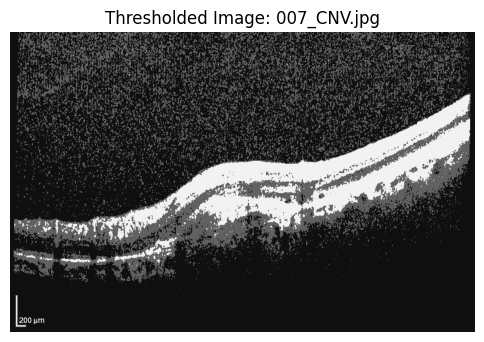

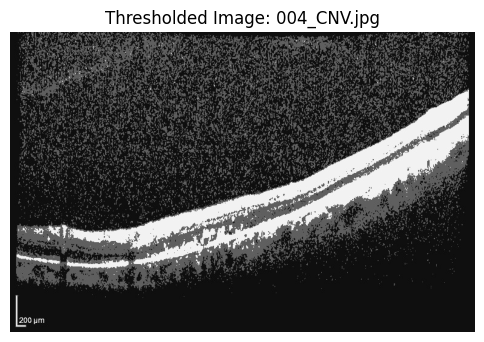

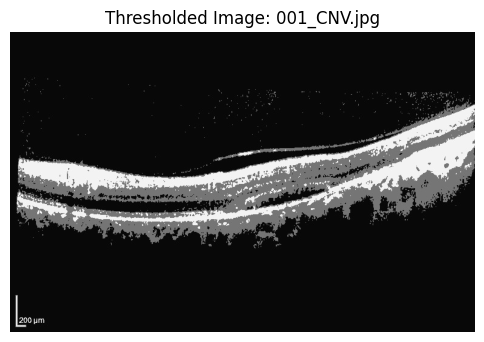

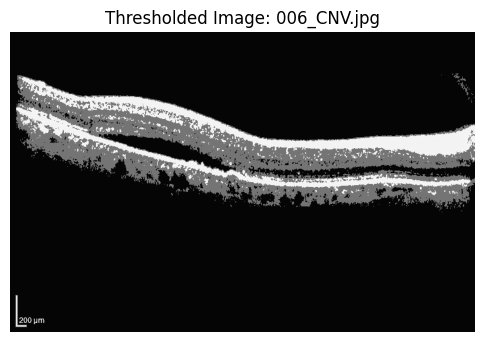

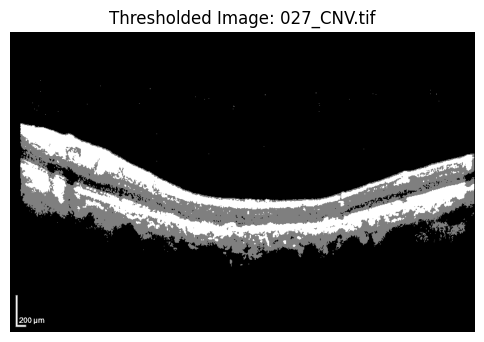

In [6]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the directory containing the thresholded images
thresholded_dir = '/content/drive/MyDrive/MultilevelThresholdedImages/'

# Get the list of images
image_files = [img for img in os.listdir(thresholded_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp', '.gif'))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the MultilevelThresholdedImages directory: {num_images}")

# Display the first 5 images
for img in image_files[:5]:
    img_path = os.path.join(thresholded_dir, img)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Thresholded Image: {img}")
    plt.axis('off')
    plt.show()


In [7]:
import cv2
import numpy as np
import os
from skimage import feature

# Define the directory containing the filtered images
filtered_data_dir = '/content/drive/MyDrive/MultilevelThresholdedImages/'

# List to store LBP features
lbp_features = []

# Iterate over the rows in the 'Directory' column of cnv
for index, row in cnv.iterrows():
    # Read the filtered image
    filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(row['Directory']))
    filtered_img = cv2.imread(filtered_img_path)

    # Check if the filtered image was successfully loaded
    if filtered_img is not None:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

        # Compute LBP features
        lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)

        # Append LBP features to the list
        lbp_features.append(hist)

# Convert the list of LBP features to a numpy array
lbp_features = np.array(lbp_features)

# Display sample LBP features
print("LBP features shape:", lbp_features.shape)
print("Sample LBP features:")
print(lbp_features[:5])

LBP features shape: (800, 9)
Sample LBP features:
[[1.21807796e-03 7.01969926e-03 2.62516801e-06 1.22201571e-02
  2.62516801e-05 3.17514071e-02 5.25033602e-06 1.43334173e-02
  9.33423114e-01]
 [2.48078377e-03 8.09864331e-03 7.87550403e-06 1.60529024e-02
  2.20514113e-04 3.97292927e-02 2.38890289e-04 1.86701949e-02
  9.14500903e-01]
 [4.12151378e-04 2.28127100e-03 2.62516801e-06 8.67092994e-03
  4.98781922e-05 2.41357947e-02 3.93775202e-05 9.83912970e-03
  9.54568842e-01]
 [1.31258401e-03 6.14814348e-03 5.25033602e-06 1.47928217e-02
  2.36265121e-04 3.27069682e-02 2.23139281e-04 1.44515499e-02
  9.30123278e-01]
 [1.01173975e-02 5.04951067e-02 1.57510081e-05 3.44789567e-02
  1.78511425e-04 5.52965390e-02 6.22164819e-04 2.36711400e-02
  8.25124433e-01]]


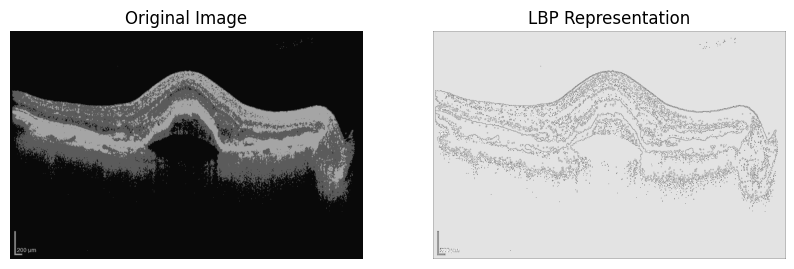

In [8]:
import cv2
import os
from skimage import feature
import matplotlib.pyplot as plt

# Function to compute LBP features for an image
def compute_lbp(image):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute LBP features
    lbp = feature.local_binary_pattern(gray_img, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return lbp, hist

# Choose an image from the dataset (you can change the index as needed)
image_index = 0
filtered_img_path = os.path.join(filtered_data_dir, os.path.basename(cnv.iloc[image_index]['Directory']))
filtered_img = cv2.imread(filtered_img_path)

# Compute LBP features for the chosen image
lbp, hist = compute_lbp(filtered_img)

# Plot the original image and its LBP representation
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# LBP representation
plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Representation')
plt.axis('off')

plt.show()

In [9]:
# Assuming you have your target vector y as a pandas Series
y = cnv['Label']

# Encode the target vector
# Assign 0 for DRUSEN, 1 for CNV, and 2 for NORMAL
y_encoded = y.map({'CNV': 0, 'NORMAL': 1})
X = lbp_features

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.50625 0.475   0.45    0.4375  0.48125]
Mean Accuracy: 0.47000000000000003


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.5     0.475   0.45    0.43125 0.49375]
Mean Accuracy: 0.47000000000000003


Degree: 1, Cross-validation scores: [0.5    0.475  0.45   0.45   0.4875]
Degree: 1, Mean Accuracy: 0.4725
Degree: 2, Cross-validation scores: [0.575   0.59375 0.59375 0.50625 0.55625]
Degree: 2, Mean Accuracy: 0.565
Degree: 3, Cross-validation scores: [0.5875  0.63125 0.59375 0.53125 0.55625]
Degree: 3, Mean Accuracy: 0.58
Degree: 4, Cross-validation scores: [0.525   0.59375 0.59375 0.50625 0.55625]
Degree: 4, Mean Accuracy: 0.5549999999999999
Degree: 5, Cross-validation scores: [0.5375  0.6     0.59375 0.5125  0.55625]
Degree: 5, Mean Accuracy: 0.5599999999999999


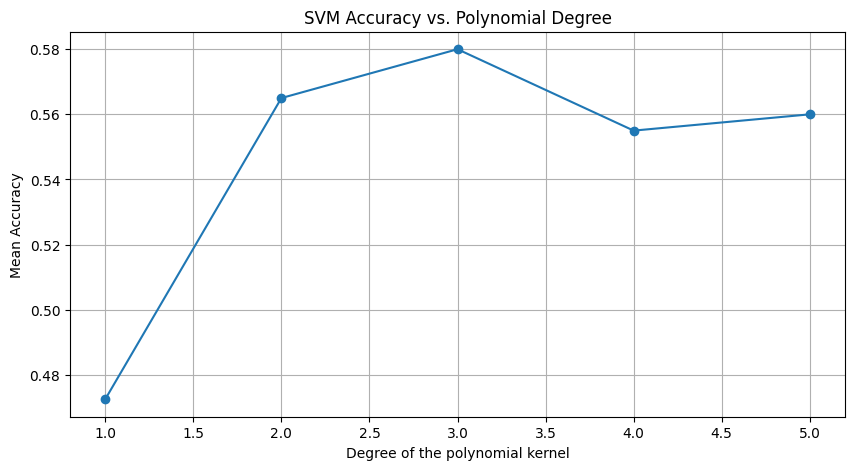

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

Gamma: 0.001, Mean Accuracy: 0.4725
Gamma: 0.01, Mean Accuracy: 0.4725
Gamma: 0.1, Mean Accuracy: 0.4725
Gamma: 1, Mean Accuracy: 0.50125
Gamma: 10, Mean Accuracy: 0.555


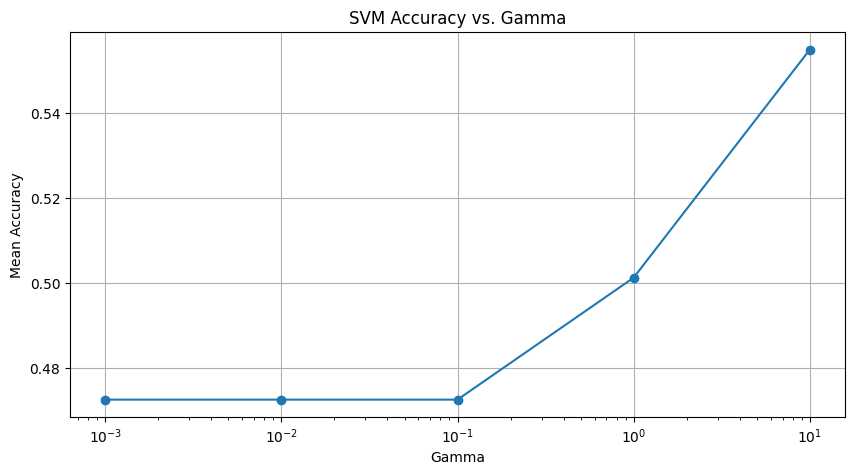

In [13]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.525   0.625   0.56875 0.50625 0.54375]
Mean Accuracy with Logistic Regression: 0.55375
Standard Deviation of Accuracy with Logistic Regression: 0.0411931426332102


In [15]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.96875 0.95625 0.95625 0.9625  0.93125]
Mean Accuracy with KNN: 0.9550000000000001
Standard Deviation of Accuracy with KNN: 0.012747548783981958


In [16]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.6125  0.6375  0.56875 0.50625 0.54375]
Mean Accuracy with Naive Bayes: 0.5737500000000001
Standard Deviation of Accuracy with Naive Bayes: 0.047003989192407926


In [17]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [0.99375 0.99375 0.99375 0.96875 0.975  ]
Mean Accuracy with XGBoost: 0.985
Standard Deviation of Accuracy with XGBoost: 0.010897247358851697
